In [1]:
import os, sys
root_dir = os.path.dirname(os.getcwd())
sys.path.append(root_dir)

In [2]:
import matplotlib as mpl
import pandas as pd
import numpy as np
import scipy.stats, os, json
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict
from matplotlib.ticker import ScalarFormatter
import wandb
from environment import WANDB_INFO

In [3]:
api = wandb.Api()

In [4]:
legend_converter = {
    'ours': ('SDT', '*', '-', '#073B4C'),
    'lora': ('LoRA', '>', ':', '#DD3497'),
    'freeze': ('Freeze', 'x', '--', '#06D6A0'), 
    'full': ('Full', 's', '-.', '#118AB2'),
}

In [5]:
def get_loss(**kwargs):
    if not 'task_type' in kwargs:
        raise Exception('task_type is required')
    task_type = kwargs['task_type']
    
    df = pd.read_pickle(f'{root_dir}/analysis/results.pkl')
    for k, v in kwargs.items():
        df = df[df[k] == v].reset_index(drop=True)
    # Assuming your DataFrame is named df and the column with dates is 'create_time'
    df['create_time'] = pd.to_datetime(df['create_time'])

    # Filter to include only rows where the create time is after 2024-05-03 00:00
    # df = df[df['create_time'] > '2024-05-03 00:00'].reset_index(drop=True)
    df = df.dropna(subset=['train_params_percent']).reset_index(drop=True)
        
    train_params_perc_set = sorted(list(set(df['train_params_percent'])))
    
    result_curve= []
    for train_param_perc in train_params_perc_set:
        result = {}
        df_train_params = df[df['train_params_percent'] == train_param_perc]
        if task_type == 'classification':
            idx = df_train_params['best_accuracy'].idxmax()
            metric = df_train_params['best_accuracy'].loc[idx].item()
        elif task_type == 'regression':
            idx = df_train_params['best_loss'].idxmin()
            metric = df_train_params['best_loss'].loc[idx].item()

        result['train_params_percent'] = train_param_perc
        result['metric'] = metric
        for column in df.columns:
            if column not in ['train_params_percent', 'best_loss']:
                result[column] = df_train_params[column].loc[idx]

        result_curve.append(result)

    return pd.DataFrame(result_curve)
    

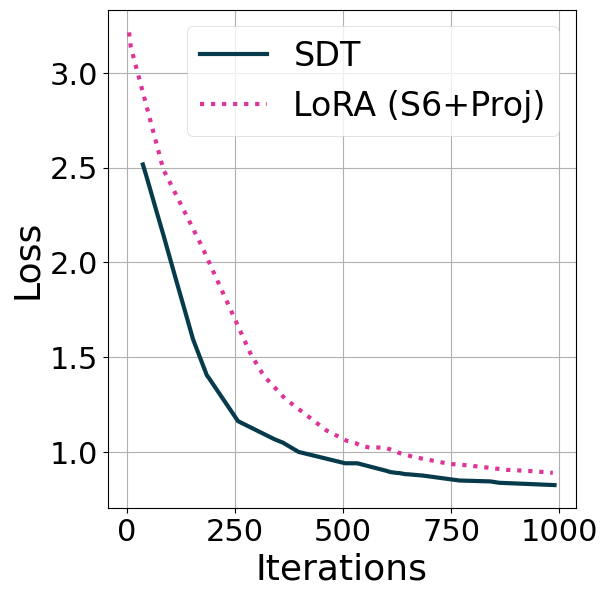

In [9]:
methods = (('ours', 'ours', 'SDT'), ('lora', 'lora', 'LoRA (S6+Proj)'))
frozen_n_layers = 8

plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 3
markersize = 6
indexs = [2,0]

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(left=0.17, bottom=.15, right=0.95, top=0.98, wspace=0.15, hspace = 0.3) #margin of the figure
fig.set_size_inches(6, 6) #exact size of the figure

for i, (lp_method, ssm_method, label) in enumerate(methods):
    df = get_loss(
        lp_method = lp_method, 
        ssm_method = ssm_method,
        ssm_warmup_method = 'ssm' if ssm_method == 'ours' else 'full',
        task_type = 'classification',
        model = 'mamba',
        embedding_method = 'freeze',
        frozen_n_layers = frozen_n_layers,
        d_model = 16,
    )

    run = api.run(f"{WANDB_INFO['entity']}/{WANDB_INFO['project']}/{df.loc[indexs[i]].run_id}")

    history = run.history()
    # Extract the loss values and steps
    steps = history["_step"]
    loss = history["best_loss"]
    plot_df = pd.DataFrame({"steps": steps, "loss": loss})
    # drop nan
    plot_df = plot_df.dropna(subset=["loss"]).reset_index(drop=True)
    plot_df = plot_df[plot_df["steps"] < 1000]
    
    ax.plot(
        plot_df["steps"],
        plot_df["loss"], 
        label = label,
        linewidth=lw,
        # markersize=markersize,
        # marker=legend_converter[lp_method][1],
        color=legend_converter[ssm_method][3],
        linestyle=legend_converter[ssm_method][2],
    )
    ax.legend(fontsize=24)
    ax.grid(True)
    ax.set_ylabel('Loss', fontsize=26)
    ax.set_xlabel('Iterations', fontsize=26)
    
plt.savefig(f'figures/mamba_depth_{frozen_n_layers}.pdf')

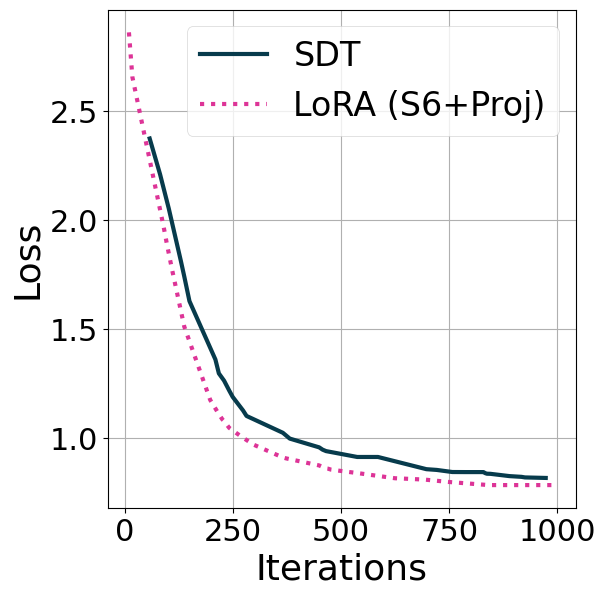

In [11]:
methods = (('ours', 'ours', 'SDT'), ('lora', 'lora', 'LoRA (S6+Proj)'))
frozen_n_layers = 16

plt.rc('xtick', labelsize=22)
plt.rc('ytick', labelsize=22)
mpl.rcParams['patch.linewidth']=0.5 #width of the boundary of legend

lw = 3
markersize = 6
indexs = [1,0]

fig, ax = plt.subplots(nrows=1, ncols=1)
fig.subplots_adjust(left=0.17, bottom=.15, right=0.95, top=0.98, wspace=0.15, hspace = 0.3) #margin of the figure
fig.set_size_inches(6, 6) #exact size of the figure

for i, (lp_method, ssm_method, label) in enumerate(methods):
    df = get_loss(
        lp_method = lp_method, 
        ssm_method = ssm_method,
        ssm_warmup_method = 'ssm' if ssm_method == 'ours' else 'full',
        task_type = 'classification',
        model = 'mamba',
        embedding_method = 'freeze',
        frozen_n_layers = frozen_n_layers,
        d_model = 16,
    )

    run = api.run(f"{WANDB_INFO['entity']}/{WANDB_INFO['project']}/{df.loc[indexs[i]].run_id}")

    history = run.history()
    # Extract the loss values and steps
    steps = history["_step"]
    loss = history["best_loss"]
    plot_df = pd.DataFrame({"steps": steps, "loss": loss})
    # drop nan
    plot_df = plot_df.dropna(subset=["loss"]).reset_index(drop=True)
    plot_df = plot_df[plot_df["steps"] < 1000]
    
    ax.plot(
        plot_df["steps"],
        plot_df["loss"], 
        label = label,
        linewidth=lw,
        # markersize=markersize,
        # marker=legend_converter[lp_method][1],
        color=legend_converter[ssm_method][3],
        linestyle=legend_converter[ssm_method][2],
    )
    ax.legend(fontsize=24)
    ax.grid(True)
    ax.set_ylabel('Loss', fontsize=26)
    ax.set_xlabel('Iterations', fontsize=26)
    
plt.savefig(f'figures/mamba_depth_{frozen_n_layers}.pdf')